# Assignment 4 sklearn

With two calls to a blackbox prediction API we can craft adversarial examples to manipulate the model toward higher and lower predictions. 

#### Imports and inits

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import roc_auc_score

from interpret.glassbox import ExplainableBoostingClassifier      # interpret ebm class
from interpret.perf import ROC                                    # ROC measure for ebm
import matplotlib.pyplot as plt                                   # for plots
import numpy as np                                                # for basic array manipulation                            
import pandas as pd                                               # for dataframe manipulation
import subprocess                                                 # to run external processes for model extraction
import time                                                       # for timers

# enables display of images in notebook
from IPython.display import Image
from IPython.display import display

# set numpy random seed for better reproducibility
SEED = 12345 
np.random.seed(SEED)

# set number of threads
NTHREAD = 4

### Define Utility Functions

#### Start global timer

In [2]:
tic = time.time()

#### Import data

In [3]:
data = pd.read_csv('hmda_train_preprocessed.csv')

#### Assign basic modeling roles

In [4]:
y_name = 'high_priced'
x_names = ['property_value_std',
               'no_intro_rate_period_std',
               'loan_amount_std',
               'income_std',
               'conforming',
               'intro_rate_period_std',
               'debt_to_income_ratio_std',
               'term_360']

## Fit model

#### Split data into train and validation partitions 

In [5]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


#### train a decision tree

In [6]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split].dropna()

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 3052, columns = 23


In [7]:
# params dict for remediated models
rem_params = {'max_bins': 512,
              'max_interaction_bins': 16,
              'interactions': 10,
              'outer_bags': 4,
              'inner_bags': 0,
              'learning_rate': 0.001,
              'validation_size': 0.25,
              'min_samples_leaf': 5,
              'max_leaves': 5,
              'early_stopping_rounds': 100.0,
              'n_jobs': NTHREAD, 
              'random_state': SEED}

rem_x_names = ['property_value_std',
               'no_intro_rate_period_std',
               'loan_amount_std',
               'income_std',
               'conforming',
               'intro_rate_period_std',
               'debt_to_income_ratio_std',
               'term_360']

# retrain
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x_names], train[y_name]) 
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x_names], valid[y_name])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)

Remediated EBM retrained with AUC: 0.7781.


## Model Extraction Attack

#### Generate synthetic data for extraction attack
For an API or model to be usable by customers or others, the system documentation must contain basic information about expected input variables. Between that information, domain knowledge, and publicly available information, an attacker can make a good guess at what the input data should look like.

In [8]:
# best guess at feature distributions
schema_dict = {'term_360': {'p': 0.9, 'dist': 'binomial'},
               'conforming': {'p': 0.9, 'dist': 'binomial'},
               'no_intro_rate_period_std': {'p': 0.9, 'dist': 'binomial'},
               'loan_amount_std': {'min': -5, 'scale': 10, 'dist': 'exponential'},
               'intro_rate_period_std': {'min': 0, 'scale': 2, 'dist': 'exponential'},
               'property_value_std': {'min': -5, 'scale': 5, 'dist': 'exponential'},
               'income_std': {'min': -5, 'scale': 25, 'dist': 'exponential'},
               'loan_to_value_ratio_std': {'mean': 1, 'scale': 1, 'dist': 'normal'},
               'debt_to_income_ratio_std': {'mean': 0, 'scale': 1, 'dist': 'normal'}}

N = 10000 # rows of simulated data

random_frame = pd.DataFrame(columns=list(schema_dict.keys())) # init empty frame
                            
np.random.seed(SEED) # same results each time cell is run    
    
for j in list(schema_dict.keys()): # loop through features
    
    # simulate normal features
    if schema_dict[j]['dist'] == 'normal':
        random_frame[j] = np.random.normal(loc=schema_dict[j]['mean'],
                                           scale=schema_dict[j]['scale'], 
                                           size=N)
    
    # simulate expontential features
    if schema_dict[j]['dist'] == 'exponential':
        random_frame[j] = schema_dict[j]['min'] + np.random.exponential(scale=schema_dict[j]['scale'], 
                                                                        size=N)
        
    # simulate binomial features
    if schema_dict[j]['dist'] == 'binomial':
        random_frame[j] = np.random.binomial(1, schema_dict[j]['p'], N)
        
# make up for no_intro_rate_period_std scale shift
random_frame['no_intro_rate_period_std'] = -4 * random_frame['no_intro_rate_period_std'] 

#### First call to blackbox model for predictions on random data

In [9]:
pd.set_option('display.max_rows', 10000)

blackbox_phat = pd.DataFrame(rem_ebm.predict(random_frame[x_names]), columns=['predictions']) 
blackbox_phat = pd.concat([random_frame.reset_index(drop=True), blackbox_phat], axis=1)

blackbox_phat

term_360  conforming  no_intro_rate_period_std  loan_amount_std  \
0            0           1                        -4         7.848707   
1            1           1                         0        49.480298   
2            1           1                        -4         0.014153   
3            1           1                        -4         7.912400   
4            1           1                        -4        -4.538403   
5            1           1                         0        -0.362895   
6            0           1                        -4        -2.339528   
7            1           1                        -4        -1.947253   
8            1           1                        -4        16.479309   
9            1           1                        -4        -1.713304   
10           1           1                        -4        -2.188677   
11           0           1                        -4         6.747285   
12           1           1                        -4         3.928128   
13           1           1                        -4        -0.026205   
14           1           1                        -4        -4.448896   
15           1           1                        -4        18.742998   
16           1           1                        -4        23.186327   
17           1           1                        -4        -4.862890   
18           0           1                         0         6.496922   
19           1           1                        -4        -1.118648   
20           1           1                        -4        -1.925288   
21           1           1                        -4        19.534100   
22           1           0                        -4        -3.263387   
23           1           1                        -4         1.479507   
24           1           1                        -4         8.151628   
25           1           1                        -4         7.157416   
26           0           1                        -4        16.057492   
27           1           1                        -4        -0.864699   
28           1           1                        -4         0.380516   
29           1           1                        -4        -1.954692   
30           1           1                        -4        -3.113753   
31           1           0                        -4        -4.096009   
32           0           1                        -4        40.834217   
33           1           1                         0        11.829261   
34           1           1                        -4         4.522062   
35           1           1                        -4        -1.006256   
36           1           1                        -4        14.629767   
37           1           1                        -4         6.189704   
38           1           0                        -4        -4.363931   
39           1           1                        -4        -2.411559   
40           1           1                        -4        -4.776950   
41           1           1                        -4        12.988018   
42           1           1                        -4         5.305423   
43           1           1                        -4        14.687833   
44           1           1                        -4        -4.102980   
45           1           1                         0        -3.660468   
46           1           1                        -4         5.968546   
47           1           1                        -4        -4.247866   
48           1           1                        -4        -1.408336   
49           1           1                        -4        -0.092341   
50           1           1                        -4         0.106865   
51           1           1                        -4        -0.718515   
52           1           1                        -4        -3.354575   
53           0           1                        -4        15.9

#### Fit stolen decision tree model

In [11]:
stolen_dt = tree.DecisionTreeClassifier(max_depth=4)
X = blackbox_phat.drop('predictions', axis=1)
y = blackbox_phat['predictions']
stolen_dt = stolen_dt.fit(X, y)

#### View stolen decision tree model

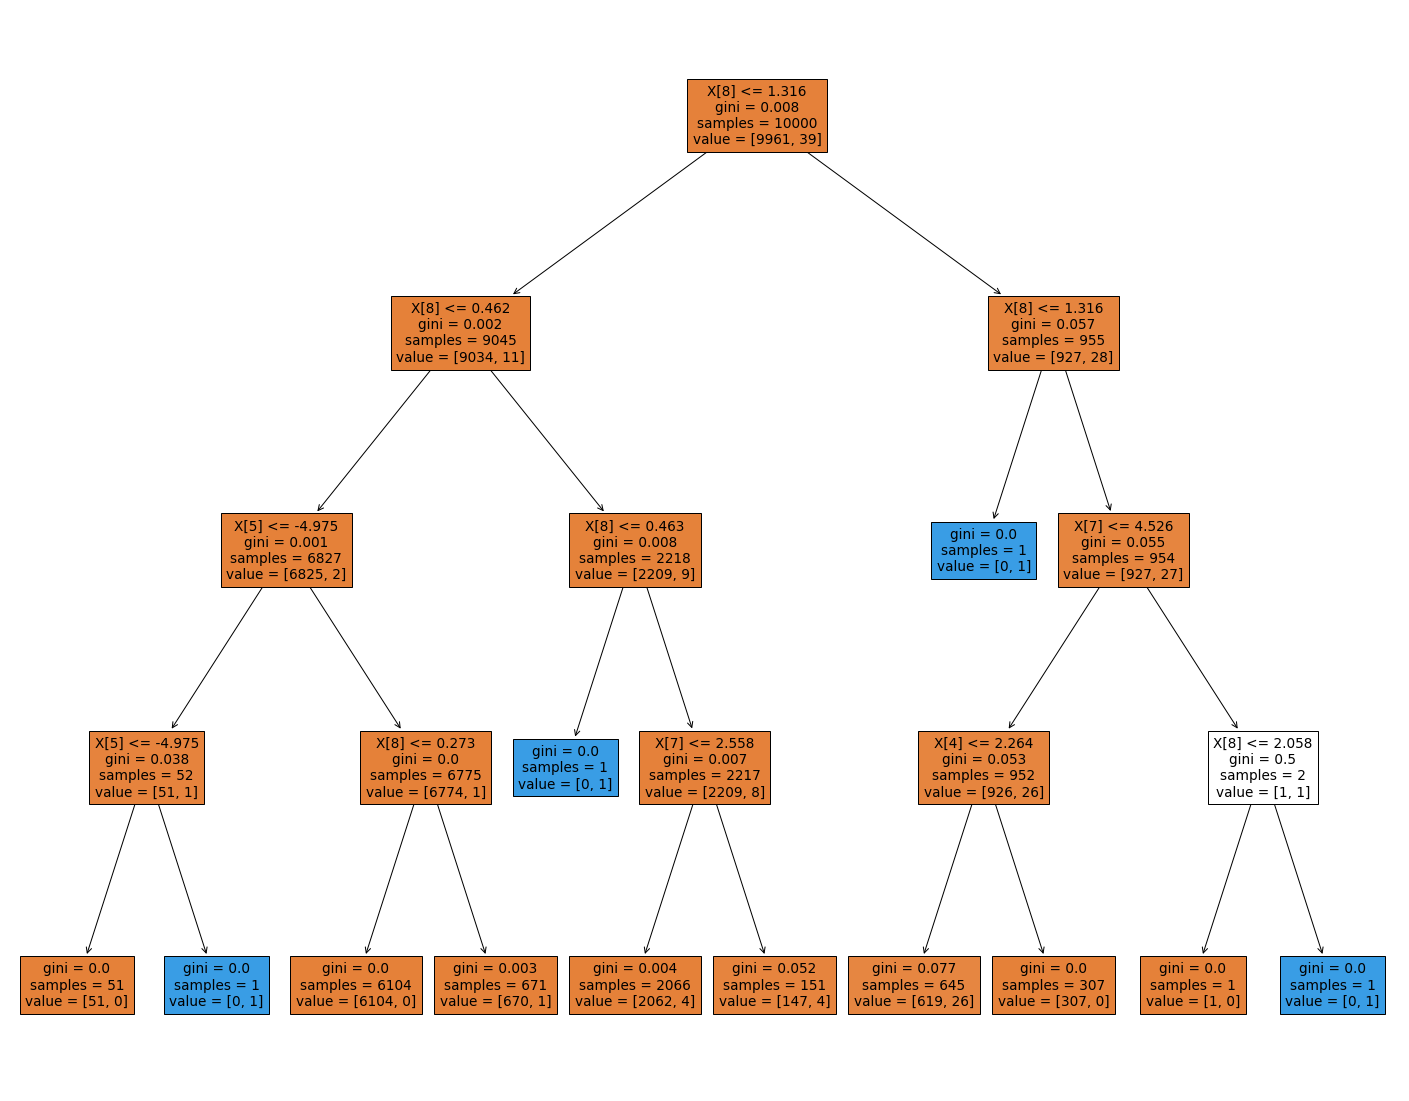

In [12]:
fig = plt.figure(figsize=(25,20))
sk_dt = tree.plot_tree(stolen_dt, filled=True)

#### Assess accuracy & feature importances of stolen model

In [13]:
roc_auc_score(y, stolen_dt.predict_proba(X)[:, 1])

0.9455105681388183

In [14]:
stolen_dt.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.0674451 ,
       0.19946725, 0.        , 0.10591764, 0.62717001])

In [15]:
import shap

shap.initjs()

  0%|          | 0/10000 [00:00<?, ?it/s]

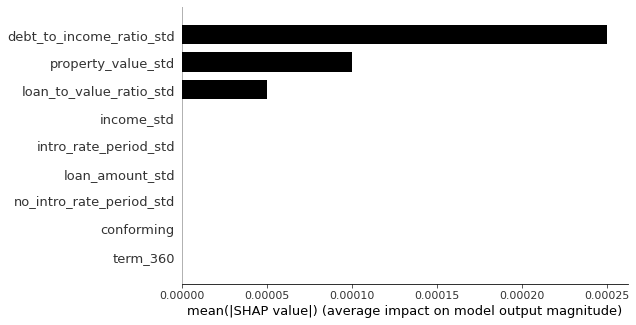

In [16]:
pred = stolen_dt.predict
summary = shap.kmeans(X, 50)
explainer = shap.KernelExplainer(pred, summary)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type='bar', color='k')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


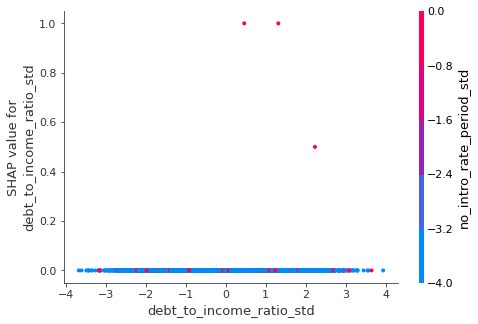

In [17]:
shap.dependence_plot(8, shap_values, X)

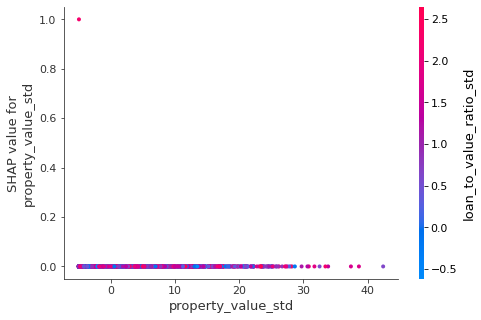

In [18]:
shap.dependence_plot(5, shap_values, X)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


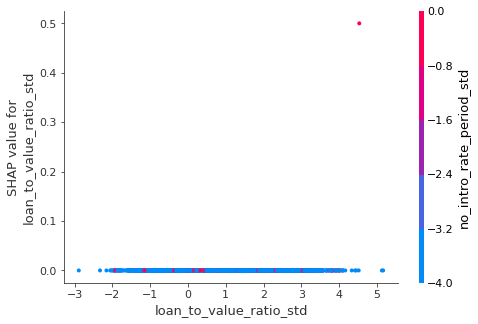

In [19]:
shap.dependence_plot(7, shap_values, X)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


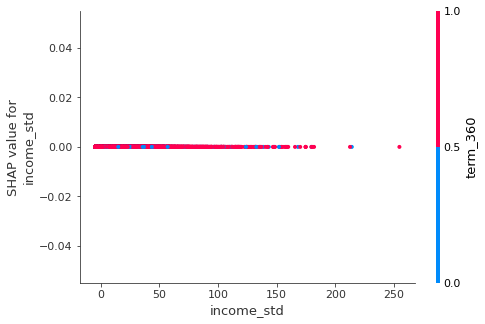

In [20]:
shap.dependence_plot(6, shap_values, X)

## Use Stolen Model to Craft Adversarial Examples

#### Use stolen model to find seed rows for adversary searches

In [45]:
low_adversary_seed = random_frame.loc[(random_frame['debt_to_income_ratio_std'] < -0.2) & 
                                      (random_frame['property_value_std'] >= 2.065) &
                                      (random_frame['loan_to_value_ratio_std'] < 0.8), :].mean()
print('Low adversarial example search seed row:')
print(low_adversary_seed)
print()

high_adversary_seed = random_frame.loc[(random_frame['debt_to_income_ratio_std'] >= 0.91) & 
                                      (random_frame['property_value_std'] < -0.7) &
                                      (random_frame['loan_to_value_ratio_std'] >= 1.1), :].mean()
print('High adversarial example search seed row:')
print(high_adversary_seed)

Low adversarial example search seed row:
term_360                     0.894495
conforming                   0.883028
no_intro_rate_period_std    -3.614679
loan_amount_std              5.552835
intro_rate_period_std        2.112317
property_value_std           6.983341
income_std                  19.465517
loan_to_value_ratio_std      0.105167
debt_to_income_ratio_std    -0.909670
dtype: float64

High adversarial example search seed row:
term_360                     0.874263
conforming                   0.893910
no_intro_rate_period_std    -3.662083
loan_amount_std              5.345517
intro_rate_period_std        1.988924
property_value_std          -3.080190
income_std                  20.872584
loan_to_value_ratio_std      1.914020
debt_to_income_ratio_std     1.472340
dtype: float64


#### Perturb seed row to find low scoring adversarial examples

In [46]:
# init results frames
low_adversary_frame = pd.DataFrame(columns=list(schema_dict.keys())) 

# quantiles over which to search 
low_quantiles = [0.01, 0.05, 0.1, 0.25, 0.5] 
high_quantiles = [0.99, 0.95, 0.9, 0.75, 0.5]

# generate potential adversarial examples across three important features
# using values of each feature and seeded by information from stolen tree
for a in list(random_frame['property_value_std'].quantile(high_quantiles)): 
        for b in list(random_frame['loan_to_value_ratio_std'].quantile(low_quantiles)):
            for c in list(random_frame['debt_to_income_ratio_std'].quantile(low_quantiles)):
                low_adversary_seed['property_value_std'] = a
                low_adversary_seed['loan_to_value_ratio_std'] = b
                low_adversary_seed['debt_to_income_ratio_std'] = c
                low_adversary_frame = low_adversary_frame.append(low_adversary_seed, 
                                                                     ignore_index=True, sort=False)
                    
# view potential low scoring adversarial examples
low_adversary_frame.head()

term_360  conforming  no_intro_rate_period_std  loan_amount_std  \
0  0.894495    0.883028                 -3.614679         5.552835   
1  0.894495    0.883028                 -3.614679         5.552835   
2  0.894495    0.883028                 -3.614679         5.552835   
3  0.894495    0.883028                 -3.614679         5.552835   
4  0.894495    0.883028                 -3.614679         5.552835   

   intro_rate_period_std  property_value_std  income_std  \
0               2.112317           18.545693   19.465517   
1               2.112317           18.545693   19.465517   
2               2.112317           18.545693   19.465517   
3               2.112317           18.545693   19.465517   
4               2.112317           18.545693   19.465517   

   loan_to_value_ratio_std  debt_to_income_ratio_std  
0                 -1.29433                 -2.408547  
1                 -1.29433                 -1.650883  
2                 -1.29433                 -1.290623  
3                 -1.29433                 -0.681455  
4                 -1.29433                 -0.011674

#### Perturb seed row to find high scoring adversarial examples

In [47]:
# init results frames
high_adversary_frame = pd.DataFrame(columns=list(schema_dict.keys())) 

# generate potential adversarial examples across three important features
# using values of each feature and seeded by information from stolen tree
for a in list(random_frame['property_value_std'].quantile(low_quantiles)): 
        for b in list(random_frame['loan_to_value_ratio_std'].quantile(high_quantiles)):
            for c in list(random_frame['debt_to_income_ratio_std'].quantile(high_quantiles)):
                high_adversary_seed['property_value_std'] = a
                high_adversary_seed['loan_to_value_ratio_std'] = b
                high_adversary_seed['debt_to_income_ratio_std'] = c
                high_adversary_frame = high_adversary_frame.append(high_adversary_seed, 
                                                                       ignore_index=True, sort=False)
                    
# view potential high scoring adversarial examples
high_adversary_frame.head()

term_360  conforming  no_intro_rate_period_std  loan_amount_std  \
0  0.874263     0.89391                 -3.662083         5.345517   
1  0.874263     0.89391                 -3.662083         5.345517   
2  0.874263     0.89391                 -3.662083         5.345517   
3  0.874263     0.89391                 -3.662083         5.345517   
4  0.874263     0.89391                 -3.662083         5.345517   

   intro_rate_period_std  property_value_std  income_std  \
0               1.988924           -4.946902   20.872584   
1               1.988924           -4.946902   20.872584   
2               1.988924           -4.946902   20.872584   
3               1.988924           -4.946902   20.872584   
4               1.988924           -4.946902   20.872584   

   loan_to_value_ratio_std  debt_to_income_ratio_std  
0                 3.322541                  2.379210  
1                 3.322541                  1.640487  
2                 3.322541                  1.295961  
3                 3.322541                  0.664197  
4                 3.322541                 -0.011674

#### Second call to blackbox API to test adversarial examples

In [48]:
# combine potential adversaries so only one call to API is needed
adversaries = pd.concat([low_adversary_frame, high_adversary_frame], axis=0)

# score potential adversarial examples to understand their effect on generated predictions
blackbox_adversaries_phat = pd.DataFrame(rem_ebm.predict_proba(adversaries[rem_x_names])[:, 1], columns=['phat']) 
blackbox_adversaries_phat = pd.concat([adversaries.reset_index(drop=True), blackbox_adversaries_phat], axis=1)
blackbox_adversaries_phat.sort_values(by='phat')

term_360  conforming  no_intro_rate_period_std  loan_amount_std  \
110  0.894495    0.883028                 -3.614679         5.552835   
100  0.894495    0.883028                 -3.614679         5.552835   
120  0.894495    0.883028                 -3.614679         5.552835   
115  0.894495    0.883028                 -3.614679         5.552835   
105  0.894495    0.883028                 -3.614679         5.552835   
90   0.894495    0.883028                 -3.614679         5.552835   
50   0.894495    0.883028                 -3.614679         5.552835   
85   0.894495    0.883028                 -3.614679         5.552835   
30   0.894495    0.883028                 -3.614679         5.552835   
80   0.894495    0.883028                 -3.614679         5.552835   
0    0.894495    0.883028                 -3.614679         5.552835   
95   0.894495    0.883028                 -3.614679         5.552835   
75   0.894495    0.883028                 -3.614679         5.552835   
70   0.894495    0.883028                 -3.614679         5.552835   
40   0.894495    0.883028                 -3.614679         5.552835   
65   0.894495    0.883028                 -3.614679         5.552835   
45   0.894495    0.883028                 -3.614679         5.552835   
60   0.894495    0.883028                 -3.614679         5.552835   
35   0.894495    0.883028                 -3.614679         5.552835   
20   0.894495    0.883028                 -3.614679         5.552835   
25   0.894495    0.883028                 -3.614679         5.552835   
55   0.894495    0.883028                 -3.614679         5.552835   
15   0.894495    0.883028                 -3.614679         5.552835   
5    0.894495    0.883028                 -3.614679         5.552835   
10   0.894495    0.883028                 -3.614679         5.552835   
121  0.894495    0.883028                 -3.614679         5.552835   
122  0.894495    0.883028                 -3.614679         5.552835   
117  0.894495    0.883028                 -3.614679         5.552835   
116  0.894495    0.883028                 -3.614679         5.552835   
112  0.894495    0.883028                 -3.614679         5.552835   
107  0.894495    0.883028                 -3.614679         5.552835   
111  0.894495    0.883028                 -3.614679         5.552835   
106  0.894495    0.883028                 -3.614679         5.552835   
101  0.894495    0.883028                 -3.614679         5.552835   
102  0.894495    0.883028                 -3.614679         5.552835   
56   0.894495    0.883028                 -3.614679         5.552835   
57   0.894495    0.883028                 -3.614679         5.552835   
92   0.894495    0.883028                 -3.614679         5.552835   
91   0.894495    0.883028                 -3.614679         5.552835   
62   0.894495    0.883028                 -3.614679         5.552835   
87   0.894495    0.883028                 -3.614679         5.552835   
66   0.894495    0.883028                 -3.614679         5.552835   
67   0.894495    0.883028                 -3.614679         5.552835   
86   0.894495    0.883028                 -3.614679         5.552835   
71   0.894495    0.883028                 -3.614679         5.552835   
72   0.894495    0.883028                 -3.614679         5.552835   
96   0.894495    0.883028                 -3.614679         5.552835   
82   0.894495    0.883028                 -3.614679         5.552835   
76   0.894495    0.883028                 -3.614679         5.552835   
77   0.894495    0.883028                 -3.614679         5.552835   
81   0.894495    0.883028                 -3.614679         5.552835   
97   0.894495    0.883028                 -3.614679         5.552835   
61   0.894495    0.883028                 -3.614679         5.552835   
12   0.894495    0.883028                 -3.614679         5.552835   
52   0.894495    0.883028                 -3.

We now have many adversarial examples that can reliably evoke extremely low and high enough predictions from the blackbox API (0.38 is likely above the cutoff for most credit models.). These can most easily be used to falsify a loan application to recieve a low-priced loan (using low adversaries). Or they could be used to ensure someone else recievces a high-priced loan. 

#### End timer

In [25]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 529.34 s.
